In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_dir = "D:/skin cancer dataset"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [3]:
image_size = (150, 150)
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

Found 6666 images belonging to 2 classes.
Found 1904 images belonging to 2 classes.
Found 952 images belonging to 2 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def squash(x, axis=-2):
    s_squared_norm = tf.reduce_sum(tf.square(x), axis=axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    return scale * x / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())

class PrimaryCaps(layers.Layer):
    def __init__(self, dim_capsule, n_channels, kernel_size, strides, padding, **kwargs):
        super(PrimaryCaps, self).__init__(**kwargs)
        self.dim_capsule = dim_capsule
        self.n_channels = n_channels
        self.conv2d = layers.Conv2D(filters=dim_capsule * n_channels, kernel_size=kernel_size,
                                    strides=strides, padding=padding)

    def call(self, inputs):
        outputs = self.conv2d(inputs)
        outputs = layers.Reshape((-1, self.dim_capsule))(outputs)
        return squash(outputs)


class DigitCaps(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routings, **kwargs):
        super(DigitCaps, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        self.W = self.add_weight(
            shape=[self.input_num_capsule, self.num_capsule, self.input_dim_capsule, self.dim_capsule],
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        # inputs: [batch_size, input_num_capsule, input_dim_capsule]
        inputs_expand = tf.expand_dims(inputs, axis=2)  # [batch, input_caps, 1, input_dim]
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsule, 1])  # [batch, input_caps, output_caps, input_dim]

        # u_hat: [batch, input_caps, output_caps, output_dim]
        u_hat = tf.einsum('bijc,ijcd->bijd', inputs_tiled, self.W)

        b_ij = tf.zeros(shape=[tf.shape(inputs)[0], self.input_num_capsule, self.num_capsule, 1])

        for i in range(self.routings):
            c_ij = tf.nn.softmax(b_ij, axis=2)  # [batch, input_caps, output_caps, 1]
            s_j = tf.reduce_sum(c_ij * u_hat, axis=1, keepdims=True)  # [batch, 1, output_caps, output_dim]
            v_j = squash(s_j, axis=-1)  # same shape

            if i < self.routings - 1:
                v_j_tiled = tf.tile(v_j, [1, self.input_num_capsule, 1, 1])  # [batch, input_caps, output_caps, output_dim]
                b_ij += tf.reduce_sum(u_hat * v_j_tiled, axis=-1, keepdims=True)  # dot product along output_dim

        return tf.squeeze(v_j, axis=1)  # [batch, output_caps, output_dim]

def CapsNet(input_shape, n_class, num_routing):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = PrimaryCaps(8, 32, 9, 2, 'valid')(x)
    digitcaps = DigitCaps(n_class, 16, num_routing)(x)
    out_caps = layers.Lambda(lambda z: tf.sqrt(tf.reduce_sum(tf.square(z), axis=2)))(digitcaps)

    return models.Model(inputs, out_caps)

model = CapsNet(input_shape=(28, 28, 1), n_class=10, num_routing=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ primary_caps (PrimaryCaps)           │ (None, 128, 8)              │       1,327,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ digit_caps (DigitCaps)               │ (None, 10, 16)              │         163,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,528,768 (5.83 MB)

 Trainable params: 1,528,768 (5.83 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def build_capsule_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = PrimaryCaps(dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')(x)
    x = DigitCaps(num_capsule=num_classes, dim_capsule=16, routings=3)(x)
    outputs = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=-1)))(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

capsule_model = build_capsule_model(image_size + (3,), 4)
capsule_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 146, 146, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ primary_caps_1 (PrimaryCaps)         │ (None, 34848, 8)            │       1,327,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ digit_caps_1 (DigitCaps)             │ (None, 4, 16)               │      17,842,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,208,256 (73.27 MB)

 Trainable params: 19,208,256 (73.27 MB)

 Non-trainable params: 0 (0.00 B)

Found 6666 images belonging to 2 classes.
Found 1904 images belonging to 2 classes.
Found 952 images belonging to 2 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,186 (426.51 KB)

 Trainable params: 109,186 (426.51 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\Dell\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 232s 552ms/step - accuracy: 0.6212 - auc: 0.6815 - loss: 0.6307 - precision: 0.6245 - recall: 0.6141 - val_accuracy: 0.5714 - val_auc: 0.5974 - val_loss: 0.7654 - val_precision: 0.5669 - val_recall: 0.6077
Epoch 2/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 228s 547ms/step - accuracy: 0.7095 - auc: 0.7994 - loss: 0.5300 - precision: 0.7028 - recall: 0.7275 - val_accuracy: 0.5662 - val_auc: 0.5968 - val_loss: 0.7912 - val_precision: 0.5682 - val_recall: 0.5751
Epoch 3/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 227s 544ms/step - accuracy: 0.7186 - auc: 0.8147 - loss: 0.5125 - precision: 0.7216 - recall: 0.7189 - val_accuracy: 0.5504 - val_auc: 0.5820 - val_loss: 0.8073 - val_precision: 0.5502 - val_recall: 0.5236
Epoch 4/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 226s 542ms/step - accuracy: 0.7331 - auc: 0.8256 - loss: 0.4998 - precision: 0.7423 - recall: 0.7093 - val_accuracy: 0.4837 - val_auc: 0.5494 - val_loss: 0.8055 - val_precision: 0.4876 - val_recall: 0.4743
Epoch 5/30
417/4

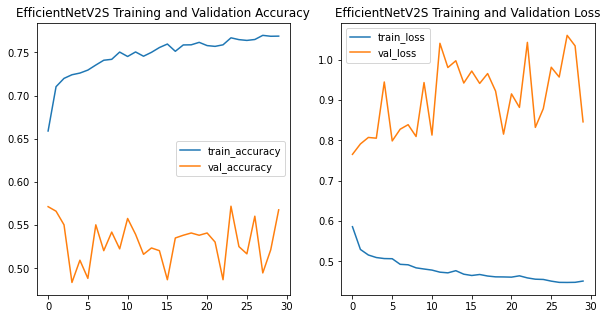

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define dataset paths
base_dir = 'D:/skin cancer dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

image_size = (150, 150)
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',  
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',  
        shuffle=False)

# EfficientNetV2S Model
from tensorflow.keras.applications import EfficientNetV2S
def EfficientNetV2S(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

model = EfficientNetV2S(input_shape=image_size + (3,), num_classes=2)
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.AUC(name='auc')]
)

model.summary()

# Train and Evaluate Function
def train_and_evaluate(model, model_name):
    history = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator
    )
    
    test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_generator)
    print(f"\n{model_name} Test Accuracy: {test_acc}")
    print(f"{model_name} Test Precision: {test_precision}")
    print(f"{model_name} Test Recall: {test_recall}")
    print(f"{model_name} Test AUC: {test_auc}")

    # Predictions and Confusion Matrix
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    print('Confusion Matrix')
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Classification report
    target_names = ['Benign','Malignant']
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Computing the accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"{model_name} Precision: {precision:.2f}")
    print(f"{model_name} Recall: {recall:.2f}")
    print(f"{model_name} F1-Score: {f1:.2f}")

    # Plotting training & validation accuracy and loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    plt.show()

train_and_evaluate(model, 'EfficientNetV2S')